In [1]:
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score

from utils.data_augmentation import rotate_keypoints_sequence
from utils.keypoints import read_keypoints, rescale_keypoints, keypoints_sequence_padding

from model.datasets import SequenceKeypointsDataset
from model.transforms import RotateKeypointsSequence, KeypointsSequencePadding
from model.models import SequenceRecognitionNet

import torch
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Sampler

from torch import nn
import torch.nn.functional as F

In [2]:
JSON_FILES_PATH = [
    './data/labels/sequence/sequence_labelsSep-16-2020_0516.json',
    './data/labels/sequence/sequence_labelsSep-16-2020_1930.json',
    './data/labels/sequence/sequence_labelsSep-18-2020_0447.json'
]
JSON_KEYPOINTS_BASE_PATH = './data/keypoints'
RANDOM_STATE = 42

N_EPOCHS = 3000
BATCH_SIZE = 32
LR = 0.00001

LABEL_OCCURENCES_MIN = 10
SEQUENCE_LENGTH_MAX = 50
NUM_CLASSES = 11

# label_map = {
#     'Meet': 0,
#     'Name': 1,
#     'Hearing person': 2,
#     'Good day': 3,
#     'You': 4,
#     'See you around': 5,
#     'Thank you': 6,
#     'Hello': 7,
#     'Bye bye': 8,
#     'Tom': 9,
#     'Woman': 10,
#     'Nice': 11,
#     'Man': 12,
#     'I': 13,
#     'My': 14
# } 

label_map = {
    'Meet': 0,
    'Name': 1,
    'Good day': 2,
    'See you around': 3,
    'Thank you': 4,
    'Hello': 5,
    'Bye bye': 6,
    'Tom': 7,
    'Nice': 8,
    'I': 9,
    'My': 10
} 

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Stack label files
labels_json = []

for label_file in JSON_FILES_PATH:
    with open(label_file, 'r') as f:
        for row in f.readlines():
            labels_json.append(json.loads(row))

            
# Fix labels
            
# Convert into DataFrame
df = pd.concat(
    [pd.DataFrame(item) for item in labels_json],
    axis=0
).drop(columns=['id'])

# Drop ignore labels
df = df[~df.label.isin(['ignore', '<random movements>', 'My name'])]

# Drop low freq classes
labels_freq = df.label.value_counts()
low_freq_labels = labels_freq[(labels_freq < LABEL_OCCURENCES_MIN)].index.tolist()
df = df[~(df.label.isin(low_freq_labels))]

df = df[df.label.isin(list(label_map.keys()))]

# Get label ID
df['label_id'] = df.label.map(label_map)

df.head()

,video_path,image_path,keypoints_path,label,label_id
0,./data/rendered_video/internal_resource_fps10/...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,Hello,5
1,./data/rendered_video/internal_resource_fps10/...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,Hello,5
2,./data/rendered_video/internal_resource_fps10/...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,Hello,5
3,./data/rendered_video/internal_resource_fps10/...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,Hello,5
4,./data/rendered_video/internal_resource_fps10/...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,Hello,5


In [4]:
df.shape

(546, 5)

In [5]:
df['length'] = df.image_path.apply(lambda x: len(x))
df.sort_values(by='length')

,video_path,image_path,keypoints_path,label,label_id,length
29,./data/rendered_video/internal_resource_2328_f...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,I,9,14
87,./data/rendered_video/internal_resource_2334_f...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,My,10,15
39,./data/rendered_video/internal_resource_fps10/...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,I,9,15
95,./data/rendered_video/internal_resource_fps10/...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,I,9,15
30,./data/rendered_video/internal_resource_2328_f...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,I,9,15
...,...,...,...,...,...,...
25,./data/rendered_video/internal_resource_2328_f...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,Good day,2,42
232,./data/rendered_video/internal_resource_2334_f...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,Tom,7,43
27,./data/rendered_video/internal_resource_fps10/...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,Good day,2,45
16,./data/rendered_video/internal_resource_fps10/...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,Good day,2,46


In [6]:
print(df.label.value_counts())
print(df.label_id.value_counts())

Hello             67
Thank you         65
Good day          62
Tom               59
Meet              57
Name              53
My                52
Nice              51
I                 36
See you around    23
Bye bye           21
Name: label, dtype: int64
5     67
4     65
2     62
7     59
0     57
1     53
10    52
8     51
9     36
3     23
6     21
Name: label_id, dtype: int64


In [7]:
def get_weights(df_train):
    class_sample_count = np.array([len(np.where(df_train.label_id==t)[0]) for t in np.unique(df_train.label_id)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in df_train.label_id])

    return torch.from_numpy(samples_weight)

In [8]:
# Train test split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

# Create Transformer
keypoints_sequence_transform_train = transforms.Compose([
    RotateKeypointsSequence(-30, 30),
    KeypointsSequencePadding(SEQUENCE_LENGTH_MAX)
])
keypoints_sequence_transform_test = transforms.Compose([
    KeypointsSequencePadding(SEQUENCE_LENGTH_MAX)
])

# Initialize Datasets
ds_train = SequenceKeypointsDataset(df_train, keypoints_sequence_transform_train)
ds_test = SequenceKeypointsDataset(df_test, keypoints_sequence_transform_test)

# Initialize Sampler
sampler = torch.utils.data.WeightedRandomSampler(get_weights(df_train), df_train.shape[0])

# Initialize DataLoader
train_dl = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, sampler=sampler)
test_dl = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE)

# Model params
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = SequenceRecognitionNet(NUM_CLASSES).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LR)

In [9]:
ds_train[0][1]

7

In [10]:
df_train.label.value_counts()

Hello             56
Tom               51
Thank you         51
My                46
Name              46
Meet              45
Good day          40
Nice              38
I                 28
See you around    18
Bye bye           17
Name: label, dtype: int64

In [11]:
df_test.label.value_counts()

Good day          22
Thank you         14
Nice              13
Meet              12
Hello             11
Tom                8
I                  8
Name               7
My                 6
See you around     5
Bye bye            4
Name: label, dtype: int64

In [12]:
@torch.no_grad()
def evaluate_model(model, data_loader, print_info=False):
    
    collect_results = []
    collect_targets = []

    for batch in data_loader:
        X, y = batch
        X = X.float().to(DEVICE)
        y = y.float().to(DEVICE).detach().cpu().numpy()

        pred = model(X)
        pred = F.softmax(pred, dim=0)
        collect_results.append(pred.detach().cpu().numpy())
        collect_targets.append(y)

    preds_proba = np.concatenate(collect_results)
    preds = preds_proba.argmax(axis=1)
    targets = np.concatenate(collect_targets)

    ll = log_loss(targets, preds_proba)
    acc = accuracy_score(targets, preds)

    
    if print_info:
        print("test log-loss: {}".format(ll))
        print("overall accuracy:  {}".format(acc))

    return ll, acc

In [13]:
metrics = []
metrics_names = ['loss_train','loss_test','acc_train','acc_test']
losses = []

net.to(DEVICE)

for epoch in range(N_EPOCHS):
    print(f'EPOCH={epoch + 1}')
    for X, y in train_dl:
        X = X.float().to(DEVICE)
        y = y.long().to(DEVICE)
        optimizer.zero_grad()
        
        y_pred = net(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.detach().cpu().numpy())
        
    train_ll, train_acc = evaluate_model(net, train_dl)
    test_ll, test_acc = evaluate_model(net, test_dl)
    
    
    print(f'train: loss={train_ll} acc={train_acc}')
    print(f'test: loss={test_ll} acc={test_acc}')
          
    metrics.append([train_ll, test_ll, train_acc, test_acc])

EPOCH=1
train: loss=2.385907916847719 acc=0.6169724770642202
test: loss=2.3863244280902616 acc=0.6284403669724771
EPOCH=2
train: loss=2.372283762748088 acc=0.6995412844036697
test: loss=2.37380380368014 acc=0.7064220183486238
EPOCH=3
train: loss=2.3582047945862517 acc=0.7247706422018348
test: loss=2.357435061844117 acc=0.7385321100917431
EPOCH=4
train: loss=2.3356982223484493 acc=0.731651376146789
test: loss=2.336757191824257 acc=0.6972477064220184
EPOCH=5
train: loss=2.308962539795342 acc=0.6215596330275229
test: loss=2.3082973262585633 acc=0.6834862385321101
EPOCH=6
train: loss=2.2681227960717787 acc=0.7110091743119266
test: loss=2.262190096422073 acc=0.7477064220183486
EPOCH=7
train: loss=2.1989481465532146 acc=0.7041284403669725
test: loss=2.2045396700364734 acc=0.7431192660550459
EPOCH=8
train: loss=2.120684069504432 acc=0.7454128440366973
test: loss=2.126212941397221 acc=0.7293577981651376
EPOCH=9
train: loss=2.0253742050140278 acc=0.7568807339449541
test: loss=2.0327136210345347

<AxesSubplot:>

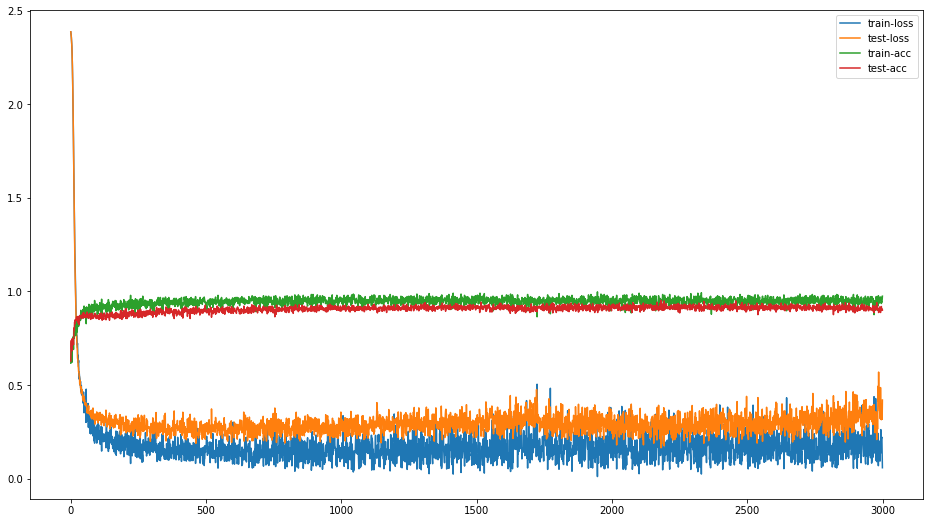

In [14]:
%matplotlib inline
pd.DataFrame(metrics, columns=['train-loss','test-loss','train-acc','test-acc']).plot(subplots=False, figsize=(16,9))

In [15]:
torch.save(net.state_dict(), './model/sequence_classifier.pt')

# m_state_dict = torch.load('mymodule.pt')
# new_m = MyModule()
# new_m.load_state_dict(m_state_dict)